In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

In [82]:
# constants
dH_1 = -74.32*1000 # kBTU/lbmol
dH_2 = -474.57*1000 # kBTU/lbmol
dp = 0.25/12 # ft
dt = 1/12 # ft
L = 20 # ft

NT = 2500 # tubes
W = 100000 # lb/h
Fc_Cpc = 10**6 # BTU/hr/C
rho_B = 100 # lb/ft3
eb = 0.5
mu = 0.048/3600 # lb/ft s
Cp = 0.50 # BTU/lbmol/C
U = 120.5 # BTU/hr/ft^2/C
Rg = 10.73/(5/9) # BTU/lbmol/C

k1 = 1.771*10**-3
k2 = 23295.0
k3 = 0.5
k4 = 1.0 
k5 = 0.8184
k6 = 0.5 
k7 = 0.2314 
k8 = 1.0 
k9 = 1.25 
k10 = 2.0
k11 = 2.795*10**-4
k12 = 33000.0
k13 = 0.5
k14 = 2.0 

# elements list
elements = ['DT', 'VA', 'O2', 'CO2', 'H2O', 'N2']
MW = [46, 44, 32, 44, 18, 28]

# initial conditions
P_T0 = 114.7 # psia
T_R0 = 353 # K
Xi_0 = [.1, 0, 0.07, 0, 0.02]
MW_0 = Xi_0[0]*MW[0] + Xi_0[2]*MW[2] + Xi_0[4]*MW[4] + (1-sum(Xi_0))*MW[-1]# lbmol/lbcat

# calculated constants
Ac = math.pi*(dt/2)**2 # ft^2

# define T horizon
dz = np.linspace(.2, L, 100)

In [79]:
# ode fxn
def odes(y, z, code):
    # retrieve updated variables
    X1, X2, X3, X4, X5, TR, TC, MW_bar, PT = y
    X = [X1, X2, X3, X4, X5]

    dydz = np.zeros(len(y))
    pp = np.zeros(9)
    A = np.array([pp, pp, pp, pp, pp, pp, pp, pp, pp])

    # Partial Pressures --> ok
    PO2 = X3*PT 
    PDT = X1*PT
    PVA = X2*PT

    # rxn rates
    RT = ((1/TR)-(1/373))/1.987
    r1 = (k1*np.exp(-k2*RT)*(PO2**k3)*(PDT**k4))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
    r2 = (k11*np.exp(-k12*RT)*(PO2**k13)*(PVA**k14))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
    
    R1 = -r1 
    R2 = r1 - r2
    R3 = -0.5*r1 - 2.5*r2
    R4 = 2*r2
    R5 = r1 + 2*r2

    R = [R1, R2, R3, R4, R5]

    # given eqs --> ok
    u = (359*14.7*W*TR)/(273*3600*NT*Ac*MW_bar*PT)
    a = 1 + (2*dp)/(3*(1-eb)*dt)

    for i in range(9):
        A[i,i] = 1
        
    for i in range(5):
        A[i,5] = -X[i]/MW_bar
    
    for i in range(5):
        A[5, i] = 28 - MW[i]
    
    b = np.zeros(9)
    
    for i in range(5): 
        b[i] = (NT*R[i]*rho_B*Ac*MW_bar)/W
    
    b[5] = 0 

    # calculate dSdz for TR
    b[6] = (-NT*Ac*rho_B*(r1*dH_1 + r2*dH_2) - math.pi*NT*dt*U*(TR-TC))/(Cp*W)

    if code == 'cocurrent':
        b[7] = math.pi*NT*dt*U*(TR-TC)/(Fc_Cpc)
    elif code == 'countercurrent':
        b[7] = - math.pi*NT*dt*U*(TR-TC)/(Fc_Cpc)

    b[8] = (-(a**2)/(32.2*144)) * ((150*mu*u/dp**2)*((1-eb)**2/eb**3) + ((1.75*MW_bar*(u**2))/(a*Rg*TR*dp))*((1-eb)/eb**3)*PT)

    dydz = np.linalg.solve(A, b)
    
    return dydz

/tmp/ipykernel_45454/554282904.py:18: RuntimeWarning: invalid value encountered in scalar power
  r1 = (k1*np.exp(-k2*RT)*(PO2**k3)*(PDT**k4))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
/tmp/ipykernel_45454/554282904.py:19: RuntimeWarning: invalid value encountered in scalar power
  r2 = (k11*np.exp(-k12*RT)*(PO2**k13)*(PVA**k14))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
/home/zahra/miniconda3/envs/HW/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/zahra/miniconda3/envs/HW/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9254416702840D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9354648726160D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9465297084605D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9605576112233D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9785737727434D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


= step size). solver will continue anyway  
      in above,  r1 =  0.2536679557396D+01   r2 =  0.2183737390966D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2536679557396D+01   r2 =  0.2183737390966D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2536679557396D+01   r2 =  0.1697013910739D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2536679557396D+01   r2 =  0.1697013910739D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue a

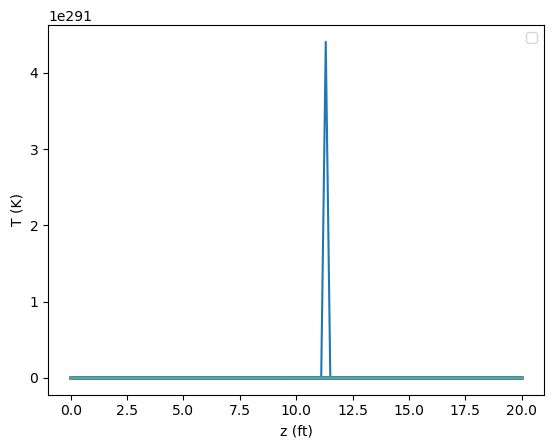

In [80]:
dz = np.linspace(0, L, 100)
y0 = np.array(Xi_0 + [T_R0, 350, MW_0, P_T0])
# Compute the solution for multiple values of TC0
TC_pts = 100
TC_values = np.linspace(350, 363, TC_pts)

TR_max = np.zeros(TC_pts)

for i in range(TC_pts):
    y0[6] = TC_values[i]
    sol = odeint(odes, y0, dz, args=('cocurrent',))
    TR_z = sol[:,5]
    plt.plot(dz, TR_z)

plt.legend()
plt.xlabel('z (ft)')
plt.ylabel('T (K)')
plt.show()

# slope = np.gradient(TR_max, TC_values) # calculate sensitivty using derivative for countercurrent 

# # Plot figure
# plot_TR_max_slope_vs_TC0(TR_max, slope, TC_values, 'cocurrent')

In [ ]:
# Plot yeild VA v z

# loop through Tc0 values
Tc0_co = [350, 352, 354, 356, 358, 360, 362, 363]
solns = []
for Tc0 in Tc0_co:
    ic = np.array(Xi_0 + [T_R0, Tc0, MW_0, P_T0])
    y_co = odeint(odes, ic, dz, args=('cocurrent',))
    solns.append(y_co)
    plt.plot(dz, y_co[:, 2], label = 'Tc0 = ' + str(Tc0))

plt.xlabel('Reactor Length (ft)')
plt.ylabel('VA Yeild')
plt.legend()
plt.show()

In [ ]:
# Plot Tc vs. z

# loop through Tc0 values
Tc0_co = [350, 352, 354, 356, 358, 360, 362, 363]
solns = []
for Tc0 in Tc0_co:
    ic = np.array(Xi_0 + [T_R0, Tc0, MW_0, P_T0])
    y_co = odeint(odes, ic, dz, args=('cocurrent',))
    solns.append(y_co)
    plt.scatter(dz, y_co[:, 6], label = 'Tc0 = ' + str(Tc0))

plt.legend()
plt.xlabel('z (ft)')
plt.ylabel('T (K)')
plt.show()

In [ ]:
# # plot - Tr v z, for multiple Tc0 (350-364 for both)
# Tr_co = y_co[:, 5]
# Tc_co = y_co[:, 6]

# plt.plot(dz, Tr_co)


# # yeild, VA v z

# # Tc v z, for multiple Tc0

# # Tr_max v for multiple Tc_0 

# # sensitvity use np.gradient (slope of Tr_max v Tc)


# plt.plot(Tr_co, Tr_co)
# plt.savefig('Tr_co.png')